# Описание

Задача:

С помощью нейросети определять температуру на поверхности обнаруженных звезд

Характеристики:

* Относительная светимость L/Lo — светимость звезды относительно Солнца.

* Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.

* Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.

* Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.

* Тип звезды.

* Тип звезды	и Номер, соответствующий типу:
    * Коричневый карлик - 0
    * Красный карлик - 1
    * Белый карлик - 2
    * Звёзды главной последовательности - 3
    * Сверхгигант - 4
    * Гипергигант - 5


* Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

## Загрузка данных

In [ ]:
# !pip install pandas
# !pip install torch
# !pip install scikit-learn==1.1.3
# !pip install matplotlib
# !pip install numpy
# !pip install pandas_profiling
# !pip install warnings
# !pip install fuzzywuzzy
# !pip install collections
# !pip install re
# !pip install math


In [ ]:

import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
# supress warnings
import warnings
from collections import Counter
import re
from scipy import stats as st
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from torch import nn
import torch
from math import ceil
from torch.optim import Adam
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_transformer


/tmp/ipykernel_124/1488078054.py:6: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport
/opt/conda/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
# игнорируем будущие ошибки
warnings.filterwarnings('ignore')

## Предобработка и анализ данных

In [ ]:
# функция для подсчетов типов
def counter_of_type(data):
    return Counter(data.dtypes)


In [ ]:
# Функция для ознакомления с данными
def preview(data,n_row=4,
             head=True,
             info=True,
             columns=True,
             shape=True,
             isna=True,
             duplicated=True,
             dtypes_=True,
            describe_=True,
           clear_duples=True,
           lower_and_sep_col=True):
    global dct_nan
    global df_nan_columns
    dct_nan = {}
    if head:
        print(f'First {n_row} row(s) in the head of data')
        display(data.head(n_row))
        print('-'*30)
    if info:
        print('Data Information:')
        display(data.info())
        print('-'*30)
    if columns:
        print('Data columns:')
        display(data.columns)
        if lower_and_sep_col:
            COLUMN_REG = "(\w) (\w)"
            repl = r"\1_\2"
            data.columns = list(map(lambda x: re.sub(COLUMN_REG,repl,x).lower(),data.columns))
            print('Lowered and sepperated by words columns:')
            print(data.columns)
            print('-'*30)
    if shape:
        print('Data shape:')
        display(data.shape)
        print('-'*30)
    if isna:
        print('Data isna by row mean:')
        display(data.isna().mean())
        print()
        tmp = data.isna().mean()
        for i in range(len(tmp)):

            if tmp[i] > 0:
                dct_nan[tmp.index[i]] = tmp[i]
        if tmp.sum() > 0:
            df_nan_columns = pd.DataFrame.from_dict(dct_nan.items())
            df_nan_columns.columns = ['column','rate_of_nan']
            display(df_nan_columns)
        print('-'*30)
    if duplicated:
        print('Data clear duplicates sum:')
        duplets = data.duplicated().sum()
        display(duplets)
        if duplets >1 and clear_duples:
            data.drop_duplicates(inplace=True)
            print('Successful delete of {0} duplicates'.format(duplets))
        elif duplets == 1 and clear_duples:
            data.drop_duplicates(inplace=True)
            print('Successful delete of {0} duplicate'.format(duplets))
        print('-'*30)
    if dtypes_:
        print('Data dtypes:')
        display(data.dtypes)
        print('Number of each type:')
        print(counter_of_type(data))
        print('-'*30)
    if describe_:
        print('Major statistics for data:')
        display(data.describe())


In [ ]:
df= pd.read_csv('/datasets/6_class.csv',index_col=0)

In [ ]:
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


In [ ]:
df.shape

(240, 6)

In [ ]:
df.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


In [ ]:
preview(df)

First 4 row(s) in the head of data


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.0024,0.1700,16.12,0,Red
1,3042,0.0005,0.1542,16.60,0,Red
2,2600,0.0003,0.1020,18.70,0,Red
3,2800,0.0002,0.1600,16.65,0,Red


------------------------------
Data Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


None

------------------------------
Data columns:


Index(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color'],
      dtype='object')

Lowered and sepperated by words columns:
Index(['temperature (k)', 'luminosity(l/lo)', 'radius(r/ro)',
       'absolute_magnitude(mv)', 'star_type', 'star_color'],
      dtype='object')
------------------------------
Data shape:


(240, 6)

------------------------------
Data isna by row mean:


temperature (k)           0.0
luminosity(l/lo)          0.0
radius(r/ro)              0.0
absolute_magnitude(mv)    0.0
star_type                 0.0
star_color                0.0
dtype: float64


------------------------------
Data clear duplicates sum:


0

------------------------------
Data dtypes:


temperature (k)             int64
luminosity(l/lo)          float64
radius(r/ro)              float64
absolute_magnitude(mv)    float64
star_type                   int64
star_color                 object
dtype: object

Number of each type:
Counter({dtype('float64'): 3, dtype('int64'): 2, dtype('O'): 1})
------------------------------
Major statistics for data:


,temperature (k),luminosity(l/lo),radius(r/ro),absolute_magnitude(mv),star_type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


In [ ]:
column_to_rep = df.columns[0]
df.rename(columns={f'{column_to_rep}':column_to_rep.replace(' (', "(")},inplace=True)

In [ ]:
# для простоты, удобства и ускорения процесса анализа
# воспользуемся библиотекой pandas_profiling
# ProfileReport(df)

In [ ]:
df.columns

Index(['temperature(k)', 'luminosity(l/lo)', 'radius(r/ro)',
       'absolute_magnitude(mv)', 'star_type', 'star_color'],
      dtype='object')

In [ ]:
def stats(data,*column):
    for c in column:
        print(f'Минимальное значение для столбца {c} = **{min(data[c])}**')
        print(f'Максимальное значение для столбца {c} = **{max(data[c])}**')
        print(f'Медианное значение для столбца {c} = **{np.median(data[c])}**')
        print(f'Среднее значение для столбца {c} = **{np.mean(data[c])}**')
        print(f'Мода для столбца {c} = **{st.mode(data[c])[0]}**')
        print(f'Стандартное отклонение для столбца {c} = **{np.std(data[c])}**')
        print(f'Коэффициент асимметрии для столбца {c} = **{st.skew(data[c])}**')
        print('-'*40)

In [ ]:
numeric_columns = df.drop(columns=['star_type','star_color'],axis=1).columns

In [ ]:
stats(df,*numeric_columns)

Минимальное значение для столбца temperature(k) = **1939**
Максимальное значение для столбца temperature(k) = **40000**
Медианное значение для столбца temperature(k) = **5776.0**
Среднее значение для столбца temperature(k) = **10497.4625**
Мода для столбца temperature(k) = **[3600]**
Стандартное отклонение для столбца temperature(k) = **9532.503378280391**
Коэффициент асимметрии для столбца temperature(k) = **1.3132941596030199**
----------------------------------------
Минимальное значение для столбца luminosity(l/lo) = **8e-05**
Максимальное значение для столбца luminosity(l/lo) = **849420.0**
Медианное значение для столбца luminosity(l/lo) = **0.07050000000000001**
Среднее значение для столбца luminosity(l/lo) = **107188.36163460833**
Мода для столбца luminosity(l/lo) = **[200000.]**
Стандартное отклонение для столбца luminosity(l/lo) = **179058.03755700908**
Коэффициент асимметрии для столбца luminosity(l/lo) = **2.0551209435208415**
----------------------------------------
Минимал

### Анализ столбцов и их природы


**Числовые:**
`temperature(k)`:

* График и выбросы:
    * График:
        * Большая часть данных лежит в районе 3600 К. Также, на графике можно заметить, что есть небольшие "курганы"
    
* Минимальное значение для столбца temperature(k) = **1939**
* Максимальное значение для столбца temperature(k) = **40000**
* Медианное значение для столбца temperature(k) = **5776.0**
* Среднее значение для столбца temperature(k) = **10497.4625**
* Мода для столбца temperature(k) = **3600**
* Стандартное отклонение для столбца temperature(k) = **9532.503378280391**
* Коэффициент асимметрии для столбца temperature(k) = **1.3132941596030199**

`luminosity(l/lo)`:

* График и выбросы:
    * График:
        * Есть основная часть, расположенная рядом с нулем, и несколько других частей, которые разделены небольшими пустотами.
    
* Минимальное значение для столбца luminosity(l/lo) = **8e-05**
* Максимальное значение для столбца luminosity(l/lo) = **849420.0**
* Медианное значение для столбца luminosity(l/lo) = **0.07050000000000001**
* Среднее значение для столбца luminosity(l/lo) = **107188.36163460833**
* Мода для столбца luminosity(l/lo) = **200000**
* Стандартное отклонение для столбца luminosity(l/lo) = **179058.03755700908**
* Коэффициент асимметрии для столбца luminosity(l/lo) = **2.0551209435208415**
*
`radius(r/ro)`:
* График и выбросы:
    * График:
        * Примерно также, как на графике у `luminosity(l/lo)`, однако между основной частью данных(~75%) и другими, есть небольшой пробел.
    
* Минимальное значение для столбца radius(r/ro) = **0.0084**
* Максимальное значение для столбца radius(r/ro) = **1948.5**
* Медианное значение для столбца radius(r/ro) = **0.7625**
* Среднее значение для столбца radius(r/ro) = **237.157781375**
* Мода для столбца radius(r/ro) = **0.11**
* Стандартное отклонение для столбца radius(r/ro) = **516.0772309183601**
* Коэффициент асимметрии для столбца radius(r/ro) = **1.9346117254577848**


`absolute_magnitude(mv)`:
* График и выбросы:
    * График:
        * Достаточно волатильный график без каких либо эксцессов
    
* Минимальное значение для столбца absolute_magnitude(mv) = **-11.92**
* Максимальное значение для столбца absolute_magnitude(mv) = **20.06**
* Медианное значение для столбца absolute_magnitude(mv) = **8.312999999999999**
* Среднее значение для столбца absolute_magnitude(mv) = **4.382395833333334**
* Мода для столбца absolute_magnitude(mv) = **12.23**
* Стандартное отклонение для столбца absolute_magnitude(mv) = **10.510546711794586**
* Коэффициент асимметрии для столбца absolute_magnitude(mv) = **-0.1207786427322443**

**Категориальные:**


`star_type`:

* График и выбросы:
    * График:
        * Гистограмма с равными интервалами.
* 0 = 40 (16.7%)
* 1 = 40 (16.7%)
* 2 = 40 (16.7%)
* 3 = 40 (16.7%)
* 4 = 40 (16.7%)
* 5 = 40 (16.7%)

`star_color`:
    
* График и выбросы:
    * График:
        * Наибольшая часть звездых объект имеют достаточно низкую температуру исходя из данных по цвету. НАиболее часто встречающий цвет - красный и разновидности синего.

* Red - 112
* Blue - 55
* Blue-white -26
* Blue White - 10
* yellow-white - 8
* Other values - 14

В этом столбце имеются дубликаты.

In [ ]:
# уникальные значения
unique_star_colour = df.star_color.unique()

In [ ]:
# обрезаем и понижаем регистр
def strip_n_low(x):
    return x.strip().lower().replace('-',' ')

In [ ]:
# применяем
df['star_color'] = df['star_color'].apply(strip_n_low)

In [ ]:
unique_star_colour

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

In [ ]:
to_replace_lst = ['blue white', 'yellowish white',
       'pale yellow orange', 'whitish', 'yellow white',
       'white yellow', 'orange red']

In [ ]:
len(to_replace_lst)

7

In [ ]:
df.query('star_color in @to_replace_lst').shape[0]/(df.shape[0])*100

23.75

**Вывод:**

**23.75%** данных нужно изменить.

In [ ]:

# Нормализация данных
scaler = StandardScaler()
df_normalized = df.loc[:, 'temperature(k)':'absolute_magnitude(mv)']
df_normalized = pd.DataFrame(scaler.fit_transform(df_normalized),columns=df_normalized.columns)

# Обучение модели
k = KMeans(n_clusters=5, random_state=7)
k.fit(df_normalized)

# Классификация строк
for i in range(5):
    print(i)
# Нахождение родственников
    numeric_columns = ['temperature(k)', 'luminosity(l/lo)', 'radius(r/rs)', 'absolute_magnitude(mv)']
    cluster_mask = (k.labels_ == i)
    cluster_rows = df[cluster_mask]

    print(cluster_rows.query('star_color in ["white","yellow","yellowish","yellow white","white yellow","yellowish white","whitish"]'))
    print('-'*40)

0
     temperature(k)  luminosity(l/lo)  radius(r/ro)  absolute_magnitude(mv)  \
21             7740          0.000490       0.01234                  14.020   
22             7220          0.000170       0.01100                  14.230   
23             8500          0.000500       0.01000                  14.500   
25            12990          0.000085       0.00984                  12.230   
27             7700          0.000110       0.01280                  14.470   
28            11790          0.000150       0.01100                  12.590   
34             5800          0.810000       0.90000                   5.050   
35             8052          8.700000       1.80000                   2.420   
36             6757          1.430000       1.12000                   2.410   
37             6380          1.350000       0.98000                   2.930   
38             5936          1.357000       1.10600                   4.460   
39             5587          0.819000       0.9900

In [ ]:
yellow = ['yellow white','white yellow','yellowish white']

In [ ]:
tmp_yellow = df.query('star_color in @yellow')

In [ ]:
yellow_index = tmp_yellow.index

In [ ]:
yellow_index

Int64Index([25, 27, 28, 34, 36, 37, 38, 39, 80, 90, 97, 219], dtype='int64')

**Вывод:**
    
KMeans определил бОльшую часть спорных цветов вместе с белыми. Так что по хорошему, нужно строить модель на двух вариантах данных. Для первой модели я заменю все `yellow white` на `yellow`, а остальные комбинации желтого и белого заменю за `yellowish`. Если результат будет очень плохой, то буду тестировать с заменой спорных данных на белые.

В окончательном варианте Гарвардской классификации основные спектральные классы звезд расположены в следующем порядке:

O — B — A — F — G — K — M

По этой классификации звезды класса:
* O – голубые
* B – голубоватые
* A – белые
* F – желтоватые
* G – желтые
* K – оранжевые
* M – красные

In [ ]:
harvard_star_classification = ['blue','blue white','white','yellow','yellowish','orange','red']

In [ ]:
harvard_star_classification

['blue', 'blue white', 'white', 'yellow', 'yellowish', 'orange', 'red']

In [ ]:
to_replace_dct={'blue white':'bluish',
'yellowish white':'yellowish',
'pale yellow orange':'orange',
 'whitish':'white',
 'yellow white':'yellow',
 'white yellow':'yellowish',
 'orange red':'red'}

In [ ]:
df['star_color'].value_counts()

red                   112
blue                   56
blue white             41
white                  10
yellow white            8
yellowish white         3
yellowish               3
orange                  2
whitish                 2
white yellow            1
orange red              1
pale yellow orange      1
Name: star_color, dtype: int64

In [ ]:
def replace_star_colour(data,replace_dct,column):
    if data[column] in to_replace_dct.keys():
        return replace_dct[data[column]]
    else:
        return data[column]

In [ ]:
df['star_color'].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'whitish', 'yellow white', 'orange',
       'white yellow', 'yellowish', 'orange red'], dtype=object)

In [ ]:
df['star_color'] = df.apply(replace_star_colour, args=(to_replace_dct, 'star_color'), axis=1)

In [ ]:
df['star_color'].unique()

array(['red', 'bluish', 'white', 'yellowish', 'orange', 'blue', 'yellow'],
      dtype=object)

In [ ]:
def categoring(data,*columns):
    for col in columns:
        data[col] = data[col].astype('category')

In [ ]:
cat_cols = ['star_type','star_color']

In [ ]:
categoring(df,*cat_cols)

In [ ]:
df.select_dtypes('category')

,star_type,star_color
0,0,red
1,0,red
2,0,red
3,0,red
4,0,red
...,...,...
235,5,blue
236,5,blue
237,5,white
238,5,white


In [ ]:
drop_to_num_col = cat_cols.copy()

In [ ]:
drop_to_num_col.append('temperature(k)')

In [ ]:
num_cols= list(df.drop(drop_to_num_col,axis=1).columns)

In [ ]:
# # Стандартизация и кодировка данных
# # сначала воспользуемся стандартными методами типа OHE и SS для числовых
# # Потом можно попробовать BE для категорий

# preprocessor = ColumnTransformer(transformers=[
#     ('num',StandardScaler(),num_cols),
#     ('cat',OneHotEncoder(),cat_cols),
# ])
# pipeline = Pipeline(steps=[('preprocessor',preprocessor)])

# X_processed = pipeline.fit_transform(df)
# # Получаем список имен столбцов
# feature_names = num_cols + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names(cat_cols))

# # Создаем преобразованную таблицу с именами столбцов
# df_processed = pd.DataFrame(X_processed, columns=feature_names)


In [ ]:
features = df.drop('temperature(k)',axis=1)
target = df['temperature(k)']

In [ ]:
rs=7

In [ ]:
features_train,features_test,target_train,target_test = train_test_split(features,target,random_state=rs,shuffle=True,test_size=0.3)

In [ ]:
features_train.shape[0] /features.shape[0]

0.7

In [ ]:
features_test.shape[0] /features.shape[0]

0.3

In [ ]:
# для сохранения колонок  remainder='passthrough'
col_transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='error'),
        cat_cols
    ),
    (
        StandardScaler(),
        num_cols
    ),
    remainder='passthrough'
)


# применяем трансформер и создаем датафрейм
X_transformed = col_transformer.fit_transform(features_train)
columns = col_transformer.named_transformers_['onehotencoder'].get_feature_names(cat_cols).tolist() + num_cols
features_train_new = pd.DataFrame(col_transformer.transform(features_train), columns=columns)
X_transformed = col_transformer.transform(features_test)
columns = col_transformer.named_transformers_['onehotencoder'].get_feature_names(cat_cols).tolist() + num_cols
features_test_new = pd.DataFrame(col_transformer.transform(features_test), columns=columns)

In [ ]:
features_train_new

,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_bluish,star_color_orange,star_color_red,star_color_white,star_color_yellow,star_color_yellowish,luminosity(l/lo),radius(r/ro),absolute_magnitude(mv)
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.020778,0.749506,-1.067965
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.558914,-0.501834,-0.700063
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.638588,-0.512352,0.879247
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.638588,-0.512208,1.295758
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.086715,2.196864,-1.355805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.635555,-0.501947,-0.319484
164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.638588,-0.512209,1.247149
165,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.638588,-0.512354,0.844935
166,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.638588,-0.511912,1.025073


In [ ]:
features_test_new

,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_bluish,star_color_orange,star_color_red,star_color_white,star_color_yellow,star_color_yellowish,luminosity(l/lo),radius(r/ro),absolute_magnitude(mv)
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.638588,-0.512350,1.022214
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.638588,-0.512219,1.403460
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.638588,-0.512087,1.266211
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.638588,-0.512346,0.760108
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.638588,-0.512356,1.090838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.460356,-0.478551,-0.981231
68,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.119722,-0.460750,-0.949779
69,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.245771,-0.337927,-0.985997
70,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.632346,-0.499555,-0.508487


## Построение базовой нейронной сети

In [ ]:
target_train.reset_index(drop=True,inplace=True)
target_test.reset_index(drop=True,inplace=True)


In [ ]:
target_train = torch.Tensor(target_train.values)
target_test = torch.Tensor(target_test.values)

In [ ]:

features_train_new = torch.Tensor(features_train_new.values)
features_test_new = torch.Tensor(features_test_new.values)

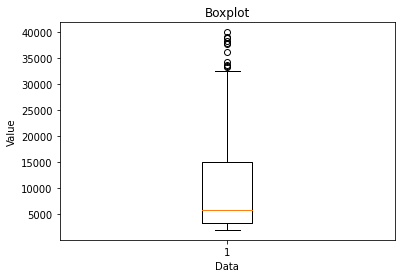

In [ ]:

# строим ящик с усами
fig, ax = plt.subplots()
ax.boxplot(df['temperature(k)'])

# добавляем название осей и заголовок
ax.set_xlabel('Data')
ax.set_ylabel('Value')
ax.set_title('Boxplot')

# показываем график
plt.show()


**Вывод:**

Выбросы очень большие, и возведение в квадрат даст слишком большие ошибки.
тобы сгладить это нужно использовать Huber Loss - сглаженная средняя абсолютная ошибка


Эта метрика менее чувствительна к выбросам:



In [ ]:
in_neurons = features_train_new.shape[1]
n_hidden_neurons = 8
n_oout_neurons = 1

In [ ]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  # добавлен вызов конструктора базового класса
        self.fc1= nn.Linear(in_neurons,n_hidden_neurons)
        self.fc2= nn.Linear(n_hidden_neurons,n_oout_neurons)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten(start_dim=0)
    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.relu(x)

net = Net()


loss = nn.HuberLoss()
optimizer = Adam(net.parameters(), lr=1e-3)
batch_size = 30

num_epochs = 10000

accumulation_iteration = 3 # делать оптимизационный шаг каждый 5-й батч

num_batches = ceil(len(features_train_new)/batch_size)

for epoch in range(num_epochs):
    # случайная перестановка объектов
    order = np.random.permutation(len(features_train_new))
    optimizer.zero_grad()
    for batch_i in range(num_batches):
        start_index = batch_i * batch_size

        # получение индексов текущего батча
        batch_indexes = order[start_index:start_index+batch_size]
        features_batch = features_train_new[batch_indexes]
        target_batch = target_train[batch_indexes]

        preds = net.forward(features_batch)

        loss_value = loss(preds, target_batch) / accumulation_iteration
        loss_value.backward()

        if ((batch_i + 1) % accumulation_iteration == 0) or (batch_i + 1 == num_batches):
            optimizer.step()
            optimizer.zero_grad()

    if epoch % 1000 == 0:
        net.eval()
        test_preds = net.forward(features_test_new)
        rmse = mean_squared_error(target_test,test_preds.detach().numpy(),squared=False)
        print(rmse)








13375.821
13265.561
13004.444
12651.48
12245.182
11868.859
11526.474
11148.951
10715.578
10438.022


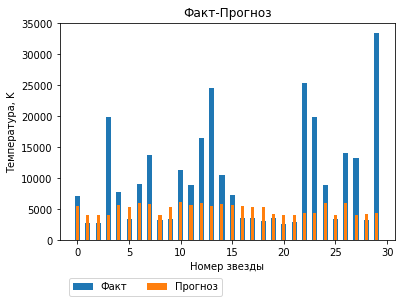

In [ ]:
# Получить количество звезд в выборке
num_stars = np.arange(30)
n= 30
preds_test_tensor = net.forward(features_test_new) # получение прогноза на тестовой выборке
# преобразование тензора прогнозов в массив numpy
preds_test = preds_test_tensor.detach().numpy().squeeze()
# Нарисовать столбчатый график
plt.bar(num_stars, target_test[:n],width=0.5, label='Факт')
plt.bar(num_stars, preds_test[:n], width=0.3,label='Прогноз')

# Настроить оси и легенду
plt.title('Факт-Прогноз')
plt.xlabel('Номер звезды')
plt.ylabel('Температура, K')

legend = plt.legend(loc='best', ncol=2, bbox_to_anchor=(0.5, -0.15))
# Отобразить график
plt.show()




Вывод:

При одном скрытом слое модель оставляет желать лучше - . Нужно подбирать параметры w и b, добавить реугляризацию и добавить еще скрытых слоев. Она предсказывает практически одинаковую температуру.


## Улучшение нейронной сети

In [ ]:
features_train_new.shape

torch.Size([168, 14])

In [ ]:
n_neurons = [14,12, 8, 4, 1]
net_layers = []

def net_model(n_neurons_=n_neurons,batch_size_=10,num_epochs_=10000,accumulatio_=2,lr_=1e-3,check_up=1000,dropout_rate=0.5):
    min_rmse = None
    net_layers = []
    for i in range(1, len(n_neurons) - 1):
        net_layers.append(nn.Linear(n_neurons[i-1],n_neurons[i]))
        if (i+1) % 2 == 0:
            net_layers.append(nn.Softplus())


        else:
            net_layers.append(nn.LeakyReLU())

        nn.Dropout(dropout_rate)
    net_layers.append(nn.Linear(n_neurons[-2], n_neurons[-1]))
    net_layers.append(nn.LeakyReLU())
    net_layers.append(nn.Flatten(start_dim=0))

    def init_weights(layer):
        if type(layer) == nn.Linear:
            nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
            nn.init.normal_(layer.bias, mean=0.5, std=1)


    net = nn.Sequential(*net_layers)

    net.apply(init_weights)


    optimizer = torch.optim.Adam(net.parameters(), lr=lr_)

    loss = nn.HuberLoss()
    batch_size = batch_size_

    num_epochs = num_epochs_

    accumulation_iteration = accumulatio_# делать оптимизационный шаг каждый n-й батч

    num_batches = ceil(len(features_train_new)/batch_size)

    for epoch in range(num_epochs):
        # случайная перестановка объектов
        order = np.random.permutation(len(features_train_new))
        optimizer.zero_grad()
        for batch_i in range(num_batches):
            start_index = batch_i * batch_size

            # получение индексов текущего батча
            batch_indexes = order[start_index:start_index+batch_size]
            features_batch = features_train_new[batch_indexes]
            target_batch = target_train[batch_indexes]

            preds = net.forward(features_batch)

            loss_value = loss(preds, target_batch) / accumulation_iteration
            loss_value.backward()

            if ((batch_i + 1) % accumulation_iteration == 0) or (batch_i + 1 == num_batches):
                optimizer.step()
                optimizer.zero_grad()

        if epoch % check_up == 0:
            net.eval()
            test_preds = net.forward(features_test_new)
            rmse = mean_squared_error(target_test,test_preds.detach().numpy(),squared=False)
            print(rmse)
            if min_rmse is not None and (rmse - min_rmse) / min_rmse * 100 > 1:
                print("RMSE увеличился более чем на 5%, что привело к остановке обучения.")
                min_rmse = rmse
                print('Наименьший RMSE на тестовой выборки без переобучения = ',min_rmse)
                break


In [ ]:
features_batch.shape

torch.Size([18, 14])

In [ ]:
net_model(n_neurons_=n_neurons,batch_size_=14,num_epochs_=10_000,accumulatio_=2,lr_=1e-3,check_up=1000)

13372.886
5578.637
4518.9424
4658.7837
4636.1465
4634.284
4612.303
4595.5737
4583.3604
4559.88


In [ ]:
net_model(n_neurons_=n_neurons,batch_size_=15,num_epochs_=10_000,accumulatio_=2,lr_=1e-2,check_up=1000)

13369.535
4438.436
4370.507
4278.1704
4221.614
4200.9907
4243.946
4260.3574
4363.722
4402.5815


In [ ]:
net_model(n_neurons_=n_neurons,batch_size_=17,num_epochs_=10_000,accumulatio_=2,lr_=1e-3,check_up=1000)

13375.412
6117.825
5193.236
4532.968
4678.853
4652.685
4639.978
4627.064
4615.3433
4606.419


## Выводы

In [ ]:
for n in np.arange(0.3,0.71,0.1):
    print(f'Для значения n = {round(n,1)}')
    net_model(n_neurons_=n_neurons,batch_size_=15,num_epochs_=10_000,accumulatio_=2,lr_=1e-2,check_up=1000,dropout_rate=n)
    print('-'*30)

Для значения n = 0.3
13375.325
4542.4106
4429.805
4296.486
4496.8574
4435.266
4489.8887
4503.503
4495.4253
4426.358
------------------------------
Для значения n = 0.4
13375.852
4473.1978
4365.403
4299.178
4166.0312
4126.713
4146.558
4110.925
4155.062
4117.67
------------------------------
Для значения n = 0.5
13374.771
4533.1665
4465.8325
4287.0894
4193.186
4195.855
4200.0947
4136.5737
4159.546
4099.78
------------------------------
Для значения n = 0.6
13374.78
4570.8745
4376.369
4479.685
4449.2407
4340.123
4238.544
4223.1484
4214.0767
4163.749
------------------------------
Для значения n = 0.7
13375.738
4436.307
4402.749
4388.4756
4272.257
4229.52
4232.131
4268.706
4129.4146
4099.162
------------------------------


In [ ]:
# Для значения n = 0.3
# 13375.325
# 4542.4106
# 4429.805
# 4296.486
# 4496.8574
# 4435.266
# 4489.8887
# 4503.503
# 4495.4253
# 4426.358
# ------------------------------
# Для значения n = 0.4
# 13375.852
# 4473.1978
# 4365.403
# 4299.178
# 4166.0312
# 4126.713
# 4146.558
# 4110.925
# 4155.062
# 4117.67
# ------------------------------
# Для значения n = 0.5
# 13374.771
# 4533.1665
# 4465.8325
# 4287.0894
# 4193.186
# 4195.855
# 4200.0947
# 4136.5737
# 4159.546
# 4099.78
# ------------------------------
# Для значения n = 0.6
# 13374.78
# 4570.8745
# 4376.369
# 4479.685
# 4449.2407
# 4340.123
# 4238.544
# 4223.1484
# 4214.0767
# 4163.749
# ------------------------------
# Для значения n = 0.7
# 13375.738
# 4436.307
# 4402.749
# 4388.4756
# 4272.257
# 4229.52
# 4232.131
# 4268.706
# 4129.4146
# 4099.162

Лучший результат при dropout_rate = 0.5

**RMSE = 4099.78**

In [ ]:
net_model(n_neurons_=n_neurons,batch_size_=15,num_epochs_=10_000,accumulatio_=2,lr_=1e-2,check_up=1000,dropout_rate=0.5)



13372.567
4456.622
4400.457
4280.8135
4239.8765
4244.9795
4200.325
4078.7588
4073.5688
4064.127


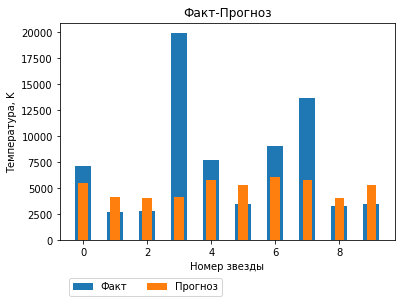

In [ ]:
# Получить количество звезд в выборке
num_stars = np.arange(10)
n= 10
preds_test_tensor = net.forward(features_test_new) # получение прогноза на тестовой выборке
# преобразование тензора прогнозов в массив numpy
preds_test = preds_test_tensor.detach().numpy().squeeze()
# Нарисовать столбчатый график
plt.bar(num_stars, target_test[:n],width=0.5, label='Факт')
plt.bar(num_stars, preds_test[:n], width=0.3,label='Прогноз')

# Настроить оси и легенду
plt.title('Факт-Прогноз')
plt.xlabel('Номер звезды')
plt.ylabel('Температура, K')

legend = plt.legend(loc='best', ncol=2, bbox_to_anchor=(0.5, -0.15))
# Отобразить график
plt.show()




In [ ]:
(4064.127)/10314.409*100

39.402422378247756

**Наименьший RMSE** равен около **4064.127**, к которому мы пришли с:
* nn.Softplus() в четным слоях
* LeakyReLU() нечетных и на выходе
* Регуляризация dropout(p=0.5) после каждого скрытого слоя
*
* Использование He инициализации с параметрами mode='fan_in', nonlinearity='relu'
* Использование нормальное отклонение с mean=0.5, std=1
* 3 скрытыми слоями с количеством нейронами `12, 8, 4` соответственно

Как видно из графика "Факт-Прогноз" модель стала относительно хорошо справляется с температурами ниже 10_000 K, выше показатели не утешают.

По сравнению с baseline моделью качество выросло на **39%**

Считаю, что это достаточно неплохой результат относительно baseline модели.